In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def stationary_bandit(k):
    q = np.random.normal(loc=0.0, scale=1.0, size=(k,))

    def env(a):
        return q, np.random.normal(loc=q[a], scale=1.0)

    return env

In [3]:
def sample_average_agent(epsilon, k):
    Q = np.zeros((k,))
    N = np.ones((k,))

    def step():
        if np.random.random() < epsilon:
            A = np.random.choice(np.arange(k))
        else:
            A = np.argmax(Q)

        R = yield A
        N[A] += 1
        Q[A] += (1 / N[A]) * (R - Q[A])

    return step

In [4]:
def run(bandit, agent, k, epsilon, epochs, samples):
    rewards = np.zeros((samples, epochs))
    optimality = np.zeros((samples, epochs))
    total = np.tile(np.arange(1, epochs + 1), (samples, 1))

    for sample in range(samples):
        env = bandit(k)
        step = agent(epsilon, k)

        for epoch in range(epochs):
            generator = step()
            A = next(generator)
            q, R = env(A)

            try:
                generator.send(R)
            except StopIteration:
                pass

            rewards[sample, epoch] = R
            optimality[sample, epoch] = int(A == np.argmax(q))

    return (
        rewards.mean(axis=0),
        (optimality.cumsum(axis=1) / total).mean(axis=0)
    )

In [11]:
def evaluate(
    bandit,
    agent,
    k=10,
    epsilons=[0, 0.1, 0.01],
    epochs=1000,
    samples=2000
):
    results = [
        run(
            stationary_bandit,
            sample_average_agent,
            k,
            epsilon,
            epochs,
            samples
        )
        for epsilon in epsilons
    ]

    fig, subplots = plt.subplots(2, 1, sharex=True)
    rewards_subplot, optimality_subplot = subplots
    
    plt.style.use("seaborn-v0_8-pastel")
     
    for epsilon, (rewards, optimality) in zip(epsilons, results):
        label = f"$\epsilon$ = {epsilon:0.2f}"

        rewards_subplot.plot(rewards, label=label)
        optimality_subplot.plot(optimality, label=label)
    
    rewards_subplot.set_ylabel("Reward")
    rewards_subplot.legend()

    optimality_subplot.set_ylabel("Optimal Action")
    optimality_subplot.set_xlabel("Step")
    optimality_subplot.legend()

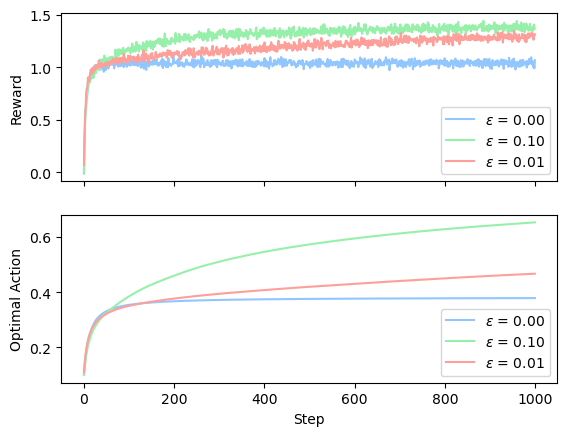

In [12]:
evaluate(stationary_bandit, sample_average_agent)